# Phase 4: Evaluation Pipeline over Synthetic Data

## 4.0. Path & Model setup

In [20]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import ks_2samp
from scipy.spatial.distance import cdist
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

BASE_SYN_DIR = Path("../output/synthetic_generation")

# Models and human-readable names
MODEL_INFO = {
    "mixup":  "Mixup",
    "corr":   "Correlation Sampling",
    "wgangp": "WGAN-GP",
    "copula": "Gaussian Copula",
    "interp": "Classwise Interpolation",
}

# Frequency band feature columns (edit if needed)
BAND_COLS = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

# Map raw condition strings to clean codes
CONDITION_MAP = {
    "S1 obj": "S1",
    "S2 match": "S2_match",
    "S2 nomatch,": "S2_nomatch",
    "S2 nomatch": "S2_nomatch",
}

CANONICAL_CONDITIONS = ["S1", "S2_match", "S2_nomatch"]

In [21]:
def load_model_data(model_key: str):
    """
    Load real and synthetic CSVs for a given model.
    Returns:
      real_X, real_y, real_c, syn_X, syn_y, syn_c
    """
    folder = BASE_SYN_DIR / model_key

    real_fp = folder / f"{model_key}_real.csv"
    syn_fp  = folder / f"{model_key}_syn.csv"

    real_df = pd.read_csv(real_fp)
    syn_df  = pd.read_csv(syn_fp)

    # Basic checks
    missing_real = [col for col in BAND_COLS + ["label", "condition"] if col not in real_df.columns]
    missing_syn  = [col for col in BAND_COLS + ["label", "condition"] if col not in syn_df.columns]
    if missing_real:
        print(f"[WARN] {model_key}_real missing columns: {missing_real}")
    if missing_syn:
        print(f"[WARN] {model_key}_syn missing columns: {missing_syn}")

    # Extract features
    real_X = real_df[BAND_COLS].to_numpy()
    syn_X  = syn_df[BAND_COLS].to_numpy()

    # Labels
    real_y = real_df["label"].to_numpy().astype(int)
    syn_y  = syn_df["label"].to_numpy().astype(int)

    # Conditions – normalize to canonical codes
    def normalize_condition(series):
        return series.map(lambda x: CONDITION_MAP.get(str(x), str(x))).to_numpy()

    real_c = normalize_condition(real_df["condition"])
    syn_c  = normalize_condition(syn_df["condition"])

    return real_X, real_y, real_c, syn_X, syn_y, syn_c

In [22]:
def compute_mmd(X, Y):
    """Maximum Mean Discrepancy using pairwise Euclidean distances."""
    XX = cdist(X, X, metric="euclidean")
    YY = cdist(Y, Y, metric="euclidean")
    XY = cdist(X, Y, metric="euclidean")
    return np.mean(XX) + np.mean(YY) - 2 * np.mean(XY)

def evaluate_distributions(real_features, synthetic_features, method_name=""):
    print(f"\n{'='*70}")
    print(f"Distribution Comparison: {method_name}")
    print("="*70)

    ks_results = []
    for i, band in enumerate(BAND_COLS):
        ks_stat, p_val = ks_2samp(real_features[:, i], synthetic_features[:, i])
        ks_results.append({"band": band, "ks_stat": ks_stat, "p_value": p_val})

        flag = "✓ Similar" if p_val > 0.05 else "✗ Different"
        print(f"{band:8s}: KS={ks_stat:.4f}, p={p_val:.4f}  {flag}")

    mmd_score = compute_mmd(real_features, synthetic_features)
    print(f"\nMMD: {mmd_score:.4f} (lower = more similar)")

    return ks_results, mmd_score

In [23]:
def evaluate_real_vs_synthetic(real_features, synthetic_features, method_name=""):
    print(f"\n{'='*70}")
    print(f"Real vs Synthetic Classification: {method_name}")
    print("="*70)

    X = np.vstack([real_features, synthetic_features])
    y = np.concatenate([
        np.ones(len(real_features)),      # real = 1
        np.zeros(len(synthetic_features)) # synthetic = 0
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_SEED
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print("Confusion matrix (rows: true [syn, real], cols: pred [syn, real]):")
    print(cm)

    return acc

In [24]:
def evaluate_tstr_trtr(real_features, real_labels, synthetic_features, method_name=""):
    print(f"\n{'='*70}")
    print(f"TSTR / TRTR: {method_name}")
    print("="*70)

    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
        real_features, real_labels, test_size=0.3, random_state=RANDOM_SEED
    )

    # Match label distribution using real train labels
    n_a = np.sum(y_train_real == 1)
    n_c = np.sum(y_train_real == 0)
    y_synth = np.concatenate([np.ones(n_a), np.zeros(n_c)])
    X_synth = synthetic_features[:len(y_synth)]

    # TRTR
    clf_trtr = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    clf_trtr.fit(X_train_real, y_train_real)
    y_pred_trtr = clf_trtr.predict(X_test_real)
    acc_trtr = accuracy_score(y_test_real, y_pred_trtr)

    # TSTR
    clf_tstr = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    clf_tstr.fit(X_synth, y_synth)
    y_pred_tstr = clf_tstr.predict(X_test_real)
    acc_tstr = accuracy_score(y_test_real, y_pred_tstr)

    gap = abs(acc_trtr - acc_tstr)

    print(f"TRTR (train real → test real): {acc_trtr:.4f}")
    print(f"TSTR (train syn  → test real): {acc_tstr:.4f}")
    print(f"Gap: {gap:.4f}")

    return acc_trtr, acc_tstr, gap


In [25]:
def eval_condition_conditional(real_X, real_y, real_c, syn_X, syn_y, syn_c, method_name):
    cond_results = {}

    print(f"\n{'='*90}")
    print(f"Condition-Conditional Evaluation: {method_name}")
    print(f"{'='*90}")

    for cond in CANONICAL_CONDITIONS:
        print(f"\n📌 Condition: {cond}")

        r_mask = (real_c == cond)
        s_mask = (syn_c == cond)

        if r_mask.sum() < 50 or s_mask.sum() < 50:
            print(f"  [Skip] Not enough samples (real={r_mask.sum()}, syn={s_mask.sum()})")
            continue

        Xr, yr = real_X[r_mask], real_y[r_mask]
        Xs, ys = syn_X[s_mask], syn_y[s_mask]

        ks, mmd = evaluate_distributions(Xr, Xs, f"{method_name} [{cond}]")
        rvs_acc = evaluate_real_vs_synthetic(Xr, Xs, f"{method_name} [{cond}]")
        trtr, tstr, gap = evaluate_tstr_trtr(Xr, yr, Xs, f"{method_name} [{cond}]")

        cond_results[cond] = {
            "ks": ks,
            "mmd": mmd,
            "real_vs_syn_acc": rvs_acc,
            "trtr": trtr,
            "tstr": tstr,
            "gap": gap,
            "n_real": int(r_mask.sum()),
            "n_syn": int(s_mask.sum()),
        }

    return cond_results

In [26]:
all_eval_results = {}

for model_key, pretty_name in MODEL_INFO.items():
    print("\n\n" + "#" * 80)
    print(f"### MODEL: {pretty_name} ({model_key})")
    print("#" * 80)

    real_X, real_y, real_c, syn_X, syn_y, syn_c = load_model_data(model_key)

    # 1. Global distribution comparison
    ks_global, mmd_global = evaluate_distributions(real_X, syn_X, pretty_name)

    # 2. Global real-vs-synthetic classification
    rvs_acc_global = evaluate_real_vs_synthetic(real_X, syn_X, pretty_name)

    # 3. Global TSTR/TRTR
    trtr_global, tstr_global, gap_global = evaluate_tstr_trtr(real_X, real_y, syn_X, pretty_name)

    # 4. Condition-conditional evaluation
    cond_results = eval_condition_conditional(
        real_X, real_y, real_c,
        syn_X, syn_y, syn_c,
        pretty_name
    )

    all_eval_results[model_key] = {
        "name": pretty_name,
        "ks_global": ks_global,
        "mmd_global": mmd_global,
        "rvs_acc_global": rvs_acc_global,
        "trtr_global": trtr_global,
        "tstr_global": tstr_global,
        "gap_global": gap_global,
        "condition_results": cond_results,
    }



################################################################################
### MODEL: Mixup (mixup)
################################################################################

Distribution Comparison: Mixup
Delta   : KS=0.1381, p=0.0000  ✗ Different
Theta   : KS=0.1263, p=0.0000  ✗ Different
Alpha   : KS=0.1324, p=0.0000  ✗ Different
Beta    : KS=0.1212, p=0.0000  ✗ Different
Gamma   : KS=0.1361, p=0.0000  ✗ Different

MMD: -0.0365 (lower = more similar)

Real vs Synthetic Classification: Mixup
Accuracy: 0.6879
Confusion matrix (rows: true [syn, real], cols: pred [syn, real]):
[[6655 2508]
 [3173 5866]]

TSTR / TRTR: Mixup
TRTR (train real → test real): 0.7527
TSTR (train syn  → test real): 0.5214
Gap: 0.2313

Condition-Conditional Evaluation: Mixup

📌 Condition: S1

Distribution Comparison: Mixup [S1]
Delta   : KS=0.1423, p=0.0000  ✗ Different
Theta   : KS=0.1263, p=0.0000  ✗ Different
Alpha   : KS=0.1357, p=0.0000  ✗ Different
Beta    : KS=0.1239, p=0.0000  ✗ Different


In [27]:
rows = []
for key, res in all_eval_results.items():
    rows.append({
        "Model Key": key,
        "Model Name": res["name"],
        "MMD (global)": res["mmd_global"],
        "Real-vs-Syn Acc (global)": res["rvs_acc_global"],
        "TRTR (global)": res["trtr_global"],
        "TSTR (global)": res["tstr_global"],
        "Gap (TRTR - TSTR)": res["gap_global"],
    })

summary_df = pd.DataFrame(rows)
summary_df.sort_values("Gap (TRTR - TSTR)", inplace=True)
summary_df

,Model Key,Model Name,MMD (global),Real-vs-Syn Acc (global),TRTR (global),TSTR (global),Gap (TRTR - TSTR)
0,mixup,Mixup,-0.036481,0.687891,0.752665,0.521371,0.231293
4,interp,Classwise Interpolation,-0.000829,0.508296,0.752665,0.511702,0.240963
2,wgangp,WGAN-GP,-0.001119,0.659818,0.752665,0.504890,0.247775
3,copula,Gaussian Copula,-0.042084,0.653664,0.752665,0.489836,0.262828
1,corr,Correlation Sampling,-0.131597,0.897704,0.752665,0.483134,0.269531


In [28]:
cond_rows = []
for key, res in all_eval_results.items():
    for cond, cres in res["condition_results"].items():
        cond_rows.append({
            "Model Key": key,
            "Model Name": res["name"],
            "Condition": cond,
            "MMD": cres["mmd"],
            "Real-vs-Syn Acc": cres["real_vs_syn_acc"],
            "TRTR": cres["trtr"],
            "TSTR": cres["tstr"],
            "Gap": cres["gap"],
            "N_real": cres["n_real"],
            "N_syn": cres["n_syn"],
        })

cond_summary_df = pd.DataFrame(cond_rows)
cond_summary_df

,Model Key,Model Name,Condition,MMD,Real-vs-Syn Acc,TRTR,TSTR,Gap,N_real,N_syn
0,mixup,Mixup,S1,-0.038782,0.677897,0.712240,0.497396,0.214844,10240,10240
1,mixup,Mixup,S2_match,-0.037405,0.713397,0.798559,0.522437,0.276122,10176,10176
2,mixup,Mixup,S2_nomatch,-0.036371,0.685148,0.771505,0.532258,0.239247,9920,9920
3,corr,Correlation Sampling,S1,-0.111402,0.885579,0.712240,0.501953,0.210286,10240,10240
4,corr,Correlation Sampling,S2_match,-0.152171,0.911399,0.798559,0.453652,0.344907,10176,10176
5,corr,Correlation Sampling,S2_nomatch,-0.141357,0.901546,0.771505,0.477487,0.294019,9920,9920
6,wgangp,WGAN-GP,S1,-0.001858,0.669759,0.712240,0.513346,0.198893,10240,10240
7,wgangp,WGAN-GP,S2_match,-0.003001,0.744677,0.798559,0.512283,0.286276,10176,10176
8,wgangp,WGAN-GP,S2_nomatch,-0.003842,0.701445,0.771505,0.492272,0.279234,9920,9920
9,copula,Gaussian Copula,S1,-0.038860,0.625651,0.712240,0.498698,0.213542,10240,10240


In [2]:
import json
import os
import pickle
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_DIR = Path("../output/band_extraction")
OUT_DIR = Path("../output/synthetic_generation")
EVAL_DIR = Path("../output/synthetic_evaluation")
EVAL_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR = EVAL_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

BAND_COLS = ["Delta", "Theta", "Alpha", "Beta", "Gamma", "total_power"]
LABEL_COL = "subject_type"
CONDITION_COL = "matching_condition"
SPLIT_COL = "dataset_split"

MODEL_NAMES = ["mixup", "corr", "wgangp", "copula", "interp"]

## 4.1. Helper Functions: Data Loading

In [3]:
def load_real_data():
    feature_fp = DATA_DIR / "band_features_segments.csv"
    if not feature_fp.exists():
        print(f"Error: Real data file not found at {feature_fp}")
        return None
    df = pd.read_csv(feature_fp)
    # Map labels: 'a' -> 1, 'c' -> 0
    df['label'] = df[LABEL_COL].map({'a': 1, 'c': 0})
    return df

def load_synthetic_data(model_name):
    # Try different possible filenames based on exploration
    file_path = OUT_DIR / model_name / f"{model_name}_syn.csv"
    if not file_path.exists():
        print(f"Warning: {file_path} not found.")
        return None
    return pd.read_csv(file_path)

## 4.2. Helper Functions: Evaluation Metrics

In [4]:
def evaluate_distributions(real_features, synthetic_features, method_name=""):
    print(f"\n{'='*60}")
    print(f"Distribution Comparison: {method_name}")
    print("="*60)
    
    ks_results = []
    print("\nKolmogorov-Smirnov Test Results:")
    for i, band in enumerate(BAND_COLS):
        if i >= real_features.shape[1]: break
        ks_stat, p_value = stats.ks_2samp(real_features[:, i], synthetic_features[:, i])
        ks_results.append({'band': band, 'ks_stat': ks_stat, 'p_value': p_value})
        significance = "✓ Similar" if p_value > 0.05 else "✗ Different"
        print(f"  {band:8s}: KS={ks_stat:.4f}, p={p_value:.4f} {significance}")
    
    # MMD
    def compute_mmd(X, Y):
        # Simplified MMD with subsampling if large
        n_sub = min(1000, len(X), len(Y))
        X_sub = X[np.random.choice(len(X), n_sub, replace=False)]
        Y_sub = Y[np.random.choice(len(Y), n_sub, replace=False)]
        
        XX = cdist(X_sub, X_sub, metric='euclidean')
        YY = cdist(Y_sub, Y_sub, metric='euclidean')
        XY = cdist(X_sub, Y_sub, metric='euclidean')
        return np.mean(XX) + np.mean(YY) - 2 * np.mean(XY)

    mmd_score = compute_mmd(real_features, synthetic_features)
    print(f"\nMMD Score: {mmd_score:.4f}")
    
    return ks_results, mmd_score

In [5]:
def evaluate_tstr_trtr(real_features, real_labels, synthetic_features, synthetic_labels, method_name=""):
    print(f"\n{'='*60}")
    print(f"TSTR/TRTR Evaluation: {method_name}")
    print("="*60)
    
    # Split real data
    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
        real_features, real_labels, test_size=0.3, random_state=RANDOM_SEED
    )
    
    # TRTR
    clf_trtr = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    clf_trtr.fit(X_train_real, y_train_real)
    acc_trtr = clf_trtr.score(X_test_real, y_test_real)
    print(f"TRTR Accuracy: {acc_trtr:.4f}")
    
    # TSTR
    clf_tstr = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    clf_tstr.fit(synthetic_features, synthetic_labels)
    acc_tstr = clf_tstr.score(X_test_real, y_test_real)
    print(f"TSTR Accuracy: {acc_tstr:.4f}")
    
    print(f"Difference: {abs(acc_trtr - acc_tstr):.4f}")
    return acc_trtr, acc_tstr

## 4.3. Helper Functions: Visualization

In [6]:
def visualize_pca_tsne(real_features, synthetic_features, method_name=""):
    # Subsample for visualization
    n_sub = min(500, len(real_features))
    idx_r = np.random.choice(len(real_features), n_sub, replace=False)
    idx_s = np.random.choice(len(synthetic_features), n_sub, replace=False)
    
    X_sub = np.vstack([real_features[idx_r], synthetic_features[idx_s]])
    y_sub = np.array(["Real"] * n_sub + ["Synthetic"] * n_sub)
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_sub)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_sub, alpha=0.6)
    plt.title(f"PCA - {method_name}")
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
    X_tsne = tsne.fit_transform(X_sub)
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_sub, alpha=0.6)
    plt.title(f"t-SNE - {method_name}")
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"pca_tsne_{method_name}.png")
    plt.show()

## 4.4. Main Evaluation Loop


Evaluating mixup...

Distribution Comparison: mixup

Kolmogorov-Smirnov Test Results:
  Delta   : KS=0.8483, p=0.0000 ✗ Different
  Theta   : KS=0.7667, p=0.0000 ✗ Different
  Alpha   : KS=0.7454, p=0.0000 ✗ Different
  Beta    : KS=0.7495, p=0.0000 ✗ Different
  Gamma   : KS=0.7009, p=0.0000 ✗ Different
  total_power: KS=0.9503, p=0.0000 ✗ Different

MMD Score: -32.9686

TSTR/TRTR Evaluation: mixup
TRTR Accuracy: 0.6907
TSTR Accuracy: 0.4711
Difference: 0.2196


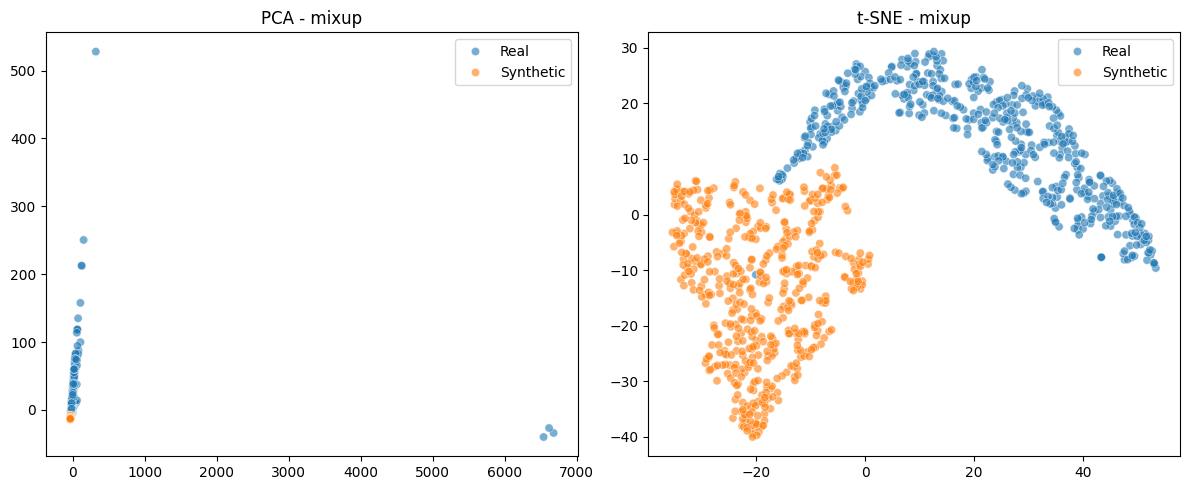


Evaluating corr...

Distribution Comparison: corr

Kolmogorov-Smirnov Test Results:
  Delta   : KS=0.8179, p=0.0000 ✗ Different
  Theta   : KS=0.6736, p=0.0000 ✗ Different
  Alpha   : KS=0.6287, p=0.0000 ✗ Different
  Beta    : KS=0.6851, p=0.0000 ✗ Different
  Gamma   : KS=0.5101, p=0.0000 ✗ Different
  total_power: KS=0.9591, p=0.0000 ✗ Different

MMD Score: -30.0936

TSTR/TRTR Evaluation: corr
TRTR Accuracy: 0.6907
TSTR Accuracy: 0.5646
Difference: 0.1262


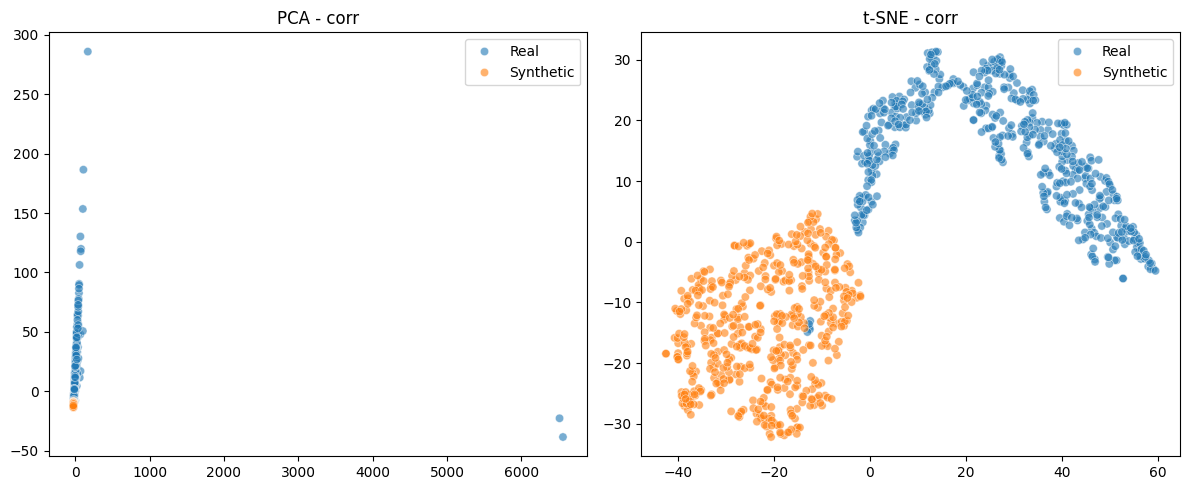


Evaluating wgangp...

Distribution Comparison: wgangp

Kolmogorov-Smirnov Test Results:
  Delta   : KS=0.8388, p=0.0000 ✗ Different
  Theta   : KS=0.7540, p=0.0000 ✗ Different
  Alpha   : KS=0.7589, p=0.0000 ✗ Different
  Beta    : KS=0.7370, p=0.0000 ✗ Different
  Gamma   : KS=0.7243, p=0.0000 ✗ Different
  total_power: KS=0.9351, p=0.0000 ✗ Different

MMD Score: -34.1410

TSTR/TRTR Evaluation: wgangp
TRTR Accuracy: 0.6907
TSTR Accuracy: 0.4821
Difference: 0.2087


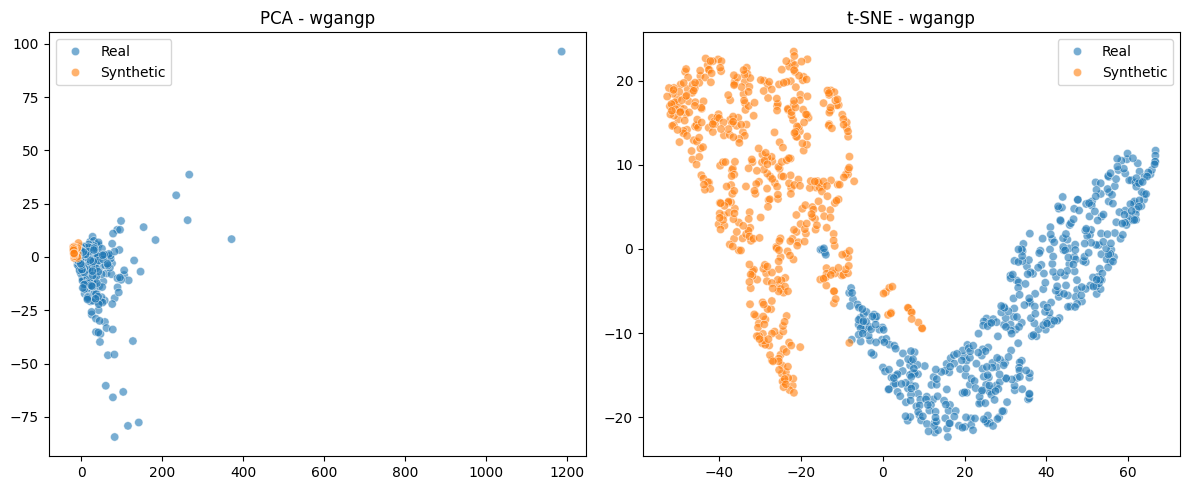


Evaluating copula...

Distribution Comparison: copula

Kolmogorov-Smirnov Test Results:
  Delta   : KS=0.7908, p=0.0000 ✗ Different
  Theta   : KS=0.7167, p=0.0000 ✗ Different
  Alpha   : KS=0.7142, p=0.0000 ✗ Different
  Beta    : KS=0.6788, p=0.0000 ✗ Different
  Gamma   : KS=0.6966, p=0.0000 ✗ Different
  total_power: KS=0.9087, p=0.0000 ✗ Different

MMD Score: -32.6924

TSTR/TRTR Evaluation: copula
TRTR Accuracy: 0.6907
TSTR Accuracy: 0.5522
Difference: 0.1385


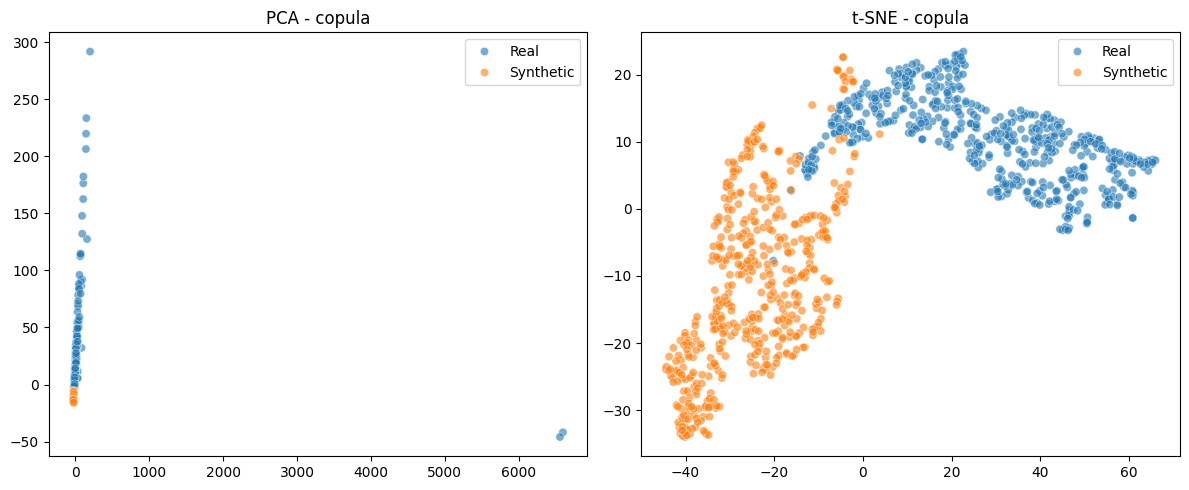


Evaluating interp...

Distribution Comparison: interp

Kolmogorov-Smirnov Test Results:
  Delta   : KS=0.8433, p=0.0000 ✗ Different
  Theta   : KS=0.7573, p=0.0000 ✗ Different
  Alpha   : KS=0.7517, p=0.0000 ✗ Different
  Beta    : KS=0.7384, p=0.0000 ✗ Different
  Gamma   : KS=0.7553, p=0.0000 ✗ Different
  total_power: KS=0.9379, p=0.0000 ✗ Different

MMD Score: -34.1917

TSTR/TRTR Evaluation: interp
TRTR Accuracy: 0.6907
TSTR Accuracy: 0.5570
Difference: 0.1337


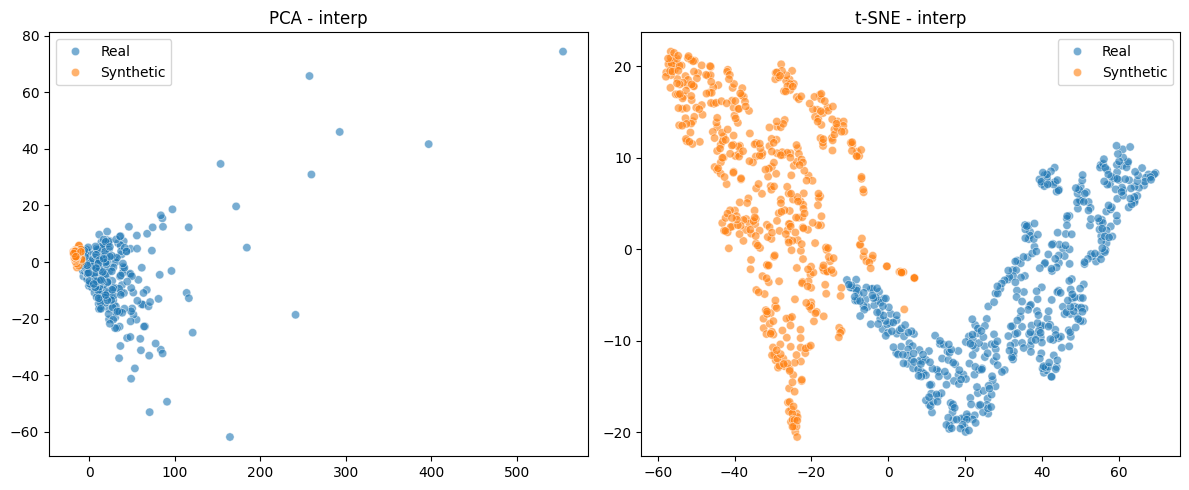


Evaluation Complete. Results saved.


In [7]:
# Load Real Data
df_real = load_real_data()
if df_real is not None:
    real_features = df_real[BAND_COLS].values
    real_labels = df_real['label'].values

    results = {}

    for model in MODEL_NAMES:
        print(f"\nEvaluating {model}...")
        df_syn = load_synthetic_data(model)
        if df_syn is None:
            continue
            
        syn_features = df_syn[BAND_COLS].values
        # Check if label column exists, otherwise we might need to handle it
        if 'label' in df_syn.columns:
            syn_labels = df_syn['label'].values
        else:
            print(f"Warning: No label column in {model} synthetic data. Skipping TSTR.")
            syn_labels = None
            
        # 1. Distributions
        ks_res, mmd = evaluate_distributions(real_features, syn_features, model)
        
        # 2. TSTR/TRTR
        tstr_res = None
        if syn_labels is not None:
            trtr, tstr = evaluate_tstr_trtr(real_features, real_labels, syn_features, syn_labels, model)
            tstr_res = {'trtr': trtr, 'tstr': tstr}
            
        # 3. Visualization
        visualize_pca_tsne(real_features, syn_features, model)
        
        results[model] = {
            'ks': ks_res,
            'mmd': mmd,
            'tstr_trtr': tstr_res
        }

    # Save results
    with open(EVAL_DIR / "evaluation_metrics.json", "w") as f:
        # Convert numpy types to python types for json serialization
        class NpEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, np.integer): return int(obj)
                if isinstance(obj, np.floating): return float(obj)
                if isinstance(obj, np.ndarray): return obj.tolist()
                return super(NpEncoder, self).default(obj)
                
        json.dump(results, f, cls=NpEncoder, indent=4)

    print("\nEvaluation Complete. Results saved.")
else:
    print("Failed to load real data.")